In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
# Functions related to positioning and distances

def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions


def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')


def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [5]:
# Functions related to channel modeling

def snr_cellfree(hor_distance, shadow):

    return db2lin(2*np.random.rand() + 10 + 96 - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

def channel_gain(snr):

    channel_matrix = np.zeros(snr.shape)
    for ap in range(snr.shape[1]):
        channel_matrix[:, ap] = np.sqrt(snr[:, ap])
        
    return channel_matrix

In [6]:
def mmse_sinr(channel_m, power_v, noise_g):

    M = channel_m.shape[1]
    sinr = np.zeros(channel_m.shape[0])
    sum = 0
    
    for ue in range(channel_m.shape[0]):
        sum += power_v[ue] * channel_m[ue] @ channel_m[ue].T
        
    for ue in range(channel_m.shape[0]):
         
        sinr[ue] = power_v[ue] * channel_m[ue].T @ np.linalg.inv(sum - channel_m[ue] @ channel_m[ue].T + np.eye(M)) @ channel_m[ue]
        
    return sinr

In [7]:
num_ue = 8
num_ap = 64
cov_side = 400
seeds = 1000
noise_gain = 1e-20 * 100e6 * db2lin(6)
noise_p = 1e-20 * 100e6

total_sinr_mp = np.zeros((num_ue, seeds))
#total_sinr_fpc = np.zeros((num_ue, seeds))


ue_pos = random_ue_positions(num_ue, cov_side)
ap_pos = ap_positions(num_ap, cov_side)
distances = distance(ue_pos, ap_pos)

for seed in range(seeds):
    shadowing = 2*np.random.randn(num_ue, num_ap)
    
    snr = snr_cellfree(distances, shadowing) 
    
    channels = channel_gain(snr)

    #power_sra = stepwise_removal(channels)[0]
    power_mp = np.ones(num_ue)
    
    total_sinr_mp[:, seed] = lin2db(mmse_sinr(channels, power_mp, noise_p))

(8000,)


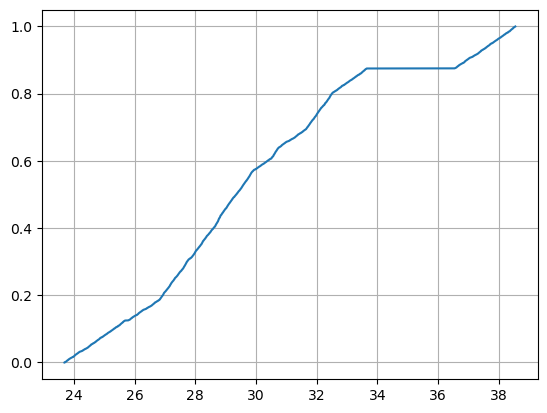

In [8]:
sinr_cdf = eCDF(total_sinr_mp.flatten())
print(sinr_cdf[0].shape)
plt.plot(sinr_cdf[0], sinr_cdf[1])

plt.grid()